# ML Experiments with Feature Store and Pipeline

In [0]:
from pyspark.sql.functions import col, when
from pyspark.sql.types import DoubleType
import pandas as pd
import matplotlib.pyplot as plt

### Load data

In [0]:
df = spark.read.csv('/Volumes/workspace/default/mlops/athletes.csv', header=True, inferSchema=True)
display(df)

athlete_id name region team affiliate gender age height weight fran helen grace filthy50 fgonebad run400 run5k candj snatch deadlift backsq pullups eat train background experience schedule howlong 2554.0 Pj Ablang South West Double Edge Double Edge CrossFit Male 24.0 70.0 166.0 null null null null null null null 220.0 null 400.0 305.0 null null I workout mostly at a CrossFit Affiliate|I have a coach who determines my programming|I record my workouts| I played youth or high school level sports|I regularly play recreational sports| I began CrossFit with a coach (e.g. at an affiliate)|I have attended one or more specialty courses|I have had a life changing experience due to CrossFit| I do multiple workouts in a day 2x a week| 4+ years| 3517.0 Derek Abdella null null null Male 42.0 70.0 190.0 null null null null 0.0 null null null null null null null null I have a coach who determines my programming|I record my workouts| I played youth or high school level sports| I began CrossFit with a coach (e.g. at an affiliate)|I have attended one or more specialty courses|I have had a life changing experience due to CrossFit| I do multiple workouts in a day 2x a week| 4+ years| 4691.0 null null null null null null null null null null null null null null null null null null null null null null null null null null 5164.0 Abo Brandon Southern California LAX CrossFit LAX CrossFit Male 40.0 67.0 null 211.0 645.0 300.0 null 196.0 null null 245.0 200.0 375.0 325.0 25.0 I eat 1-3 full cheat meals per week| I workout mostly at a CrossFit Affiliate|I have a coach who determines my programming|I record my workouts| I played youth or high school level sports| I began CrossFit by trying it alone (without a coach)|I began CrossFit with a coach (e.g. at an affiliate)|I have completed the CrossFit Level 1 certificate course|I have attended one or more specialty courses|I have had a life changing experience due to CrossFit|I train other people| I usually only do 1 workout a day| 4+ years| 5286.0 Bryce Abbey null null null Male 32.0 65.0 149.0 206.0 465.0 null 1053.0 null null 1081.0 205.0 150.0 null 325.0 50.0 I eat quality foods but don't measure the amount| I workout mostly at a CrossFit Affiliate|I incorporate CrossFit.com workouts|I write my own programming|I record my workouts| I played college sports| I began CrossFit by trying it alone (without a coach)|I have completed the CrossFit Level 1 certificate course|I train other people| I usually only do 1 workout a day|I strictly schedule my rest days| 1-2 years| 6491.0 Jason Abney null null null Male 37.0 73.0 230.0 null null null null null null null 265.0 200.0 435.0 414.0 null I eat strict Paleo| I workout mostly at a CrossFit Affiliate|I record my workouts| I played youth or high school level sports| I began CrossFit by trying it alone (without a coach)|I have completed the CrossFit Level 1 certificate course|I have had a life changing experience due to CrossFit|I train other people| I usually only do 1 workout a day|I typically rest 4 or more days per month| 4+ years| 6610.0 Anthony Abeel South Central Get Lifted Get Lifted CrossFit Male 21.0 72.0 175.0 null null null null 0.0 null null 0.0 0.0 0.0 0.0 0.0 I eat quality foods but don't measure the amount|I eat 1-3 full cheat meals per week| I workout mostly at a CrossFit Affiliate|I have a coach who determines my programming| I have no athletic background besides CrossFit| I began CrossFit with a coach (e.g. at an affiliate)|I have completed the CrossFit Level 1 certificate course|I have had a life changing experience due to CrossFit|I train other people| I do multiple workouts in a day 3+ times a week|I typically rest fewer than 4 days per month| 2-4 years| 7268.0 null null null null null null null null null null null null null null null null null null null null null null null null null null 7463.0 Tye Abell null null null Male 30.0 72.0 175.0 null null null null 0.0 null null 0.0 0.0 0.0 0.0 0.0 null null null null null null 8242.0 Ryan Achilles nul

### Data Cleaning

In [0]:
# Drop missing values in important columns
df = df.dropna(subset=['region','age','weight','height','howlong','gender','eat', \
                            'train','background','experience','schedule','howlong', \
                            'deadlift','candj','snatch','backsq','experience',\
                            'background','schedule','howlong'])

# Remove Outliers

df = df.filter(col('weight') < 1500)
df = df.filter(col('gender') != '--')
df = df.filter(col('age') >= 18)
df = df.filter((col('height') > 48) & (col('height') < 96))
df = df.filter(
    ((col('deadlift') > 0) & (col('deadlift') <= 1105)) |
    ((col('gender') == 'Female') & (col('deadlift') <= 636))
)
df = df.filter((col('candj') > 0) & (col('candj') <= 395))
df = df.filter((col('snatch') > 0) & (col('snatch') <= 496))
df = df.filter((col('backsq') > 0) & (col('backsq') <= 1069))

# Clean Survey df
df = df.replace('Decline to answer|', None, subset=['background', 'experience', 'schedule', 'howlong', 'eat'])

df = df.dropna(subset=['background', 'experience', 'schedule', 'howlong', 'eat'])

# Calculate total lift
df = df.withColumn('total_lift',col('deadlift') + col('candj') + col('snatch') + col('backsq'))
df = df.drop('deadlift', 'candj', 'snatch', 'backsq')

### Feature Store 2 Versions

In [0]:
df_v1 = df.select('athlete_id','gender','age','height','weight','howlong')
df_v2 = df.select('athlete_id','gender','age','height','weight','howlong','fran','fgonebad','filthy50','grace','helen','run400','run5k')

In [0]:
from databricks.feature_store import FeatureStoreClient

spark.sql('CREATE DATABASE IF NOT EXISTS feature_store')
fs = FeatureStoreClient()

# Register 2 feature versions
fs.create_table('feature_store.athletes_v1', primary_keys=['athlete_id'], schema=df_v1.schema, description='Basic information')
fs.write_table('feature_store.athletes_v1', df_v1)

fs.create_table('feature_store.athletes_v2', primary_keys=['athlete_id'], schema=df_v2.schema, description='Basic information and fitness stats')
fs.write_table('feature_store.athletes_v2', df_v2)

#### Create 2 training set

In [0]:
from databricks.feature_store import FeatureLookup

feature_lookups_v1 = [
    FeatureLookup(
        table_name='feature_store.athletes_v1',
        lookup_key='athlete_id'
    )
]

training_set_v1 = fs.create_training_set(
    df=df.select('athlete_id','total_lift'),
    feature_lookups=feature_lookups_v1,
    label='total_lift',
    exclude_columns=['athlete_id']
)

feature_lookups_v2 = [
    FeatureLookup(
        table_name='feature_store.athletes_v2',
        lookup_key='athlete_id'
    )
]

training_set_v2 = fs.create_training_set(
    df=df.select('athlete_id','total_lift'),
    feature_lookups=feature_lookups_v2,
    label='total_lift',
    exclude_columns=['athlete_id']
)

# Convert to pandas to be used in sklearn pipeline
training_set_v1 = training_set_v1.load_df().toPandas()
training_set_v2 = training_set_v2.load_df().toPandas()


### ML Pipeline

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
from codecarbon import EmissionsTracker

In [0]:
numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='mean'))
      ,('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='most_frequent'))
      ,('encoder', OrdinalEncoder())
])

In [0]:
mlflow.set_experiment('/Workspace/Users/adqnguyen@uchicago.edu/athletes_experiments')

# Function for training the data
def train_model(feature_version, training_set, num_var, cat_var, num_estimators, max_depth):
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
    training_set.drop(columns=['total_lift']),
    training_set['total_lift'],
    test_size=0.25,
    random_state=32021)

    # Impute and scale variables
    numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='mean'))
      ,('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='constant'))
      ,('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
    
    preprocessor = ColumnTransformer(transformers=[
    ('numeric', numeric_transformer, num_var)
   ,('categorical', categorical_transformer, cat_var)
   ]) 
    
    # Model pipeline
    pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor), 
    ('regressor',RandomForestRegressor(n_estimators=num_estimators, max_depth=max_depth))])

    with mlflow.start_run(run_name=f'{feature_version}_RF_{num_estimators}_{max_depth}') as run:
        # Train model
        tracker = EmissionsTracker()
        tracker.start()

        rf = pipeline.fit(X_train, y_train)
        y_pred = rf.predict(X_test)

        tracker.stop()
        carbon_emissions = tracker.final_emissions

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mlflow.log_param('feature_version', feature_version)
        mlflow.log_params({'num_estimators': num_estimators, 'max_depth': max_depth})        
        mlflow.log_metric('mse', mse)
        mlflow.log_metric('r2', r2)
        mlflow.log_metric('carbon_kg', carbon_emissions)

        #Residual plot
        plt.figure()
        residuals = y_test - y_pred
        plt.scatter(y_test, residuals)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Actual')
        plt.ylabel('Residuals')
        plt.title(f'Residual plot {feature_version}_RF_{num_estimators}_{max_depth}')
        plot_path = f'residuals_{feature_version}_{num_estimators}_{max_depth}.png'
        plt.savefig(plot_path)
        mlflow.log_artifact(plot_path)


[codecarbon WARNING @ 05:11:15] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 05:11:15] Error while trying to count physical CPUs: invalid literal for int() with base 10: '-'. Defaulting to 1.
[codecarbon INFO @ 05:11:15] [setup] RAM Tracking...
[codecarbon INFO @ 05:11:15] [setup] CPU Tracking...
[codecarbon WARNING @ 05:11:15] We were unable to detect your CPU using the `cpuinfo` package. Resorting to a default power consumption.
[codecarbon WARNING @ 05:11:15] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 05:11:15] CPU Model on constant consumption mode: Unknown
[codecarbon WARNING @ 05:11:15] No CPU tracking mode found. Falling back on CPU load mode.
[codecarbon INFO @ 05:11:15] [setup] GPU Tracking...
[codecarbon INFO @ 05:11:15] No GPU found.
[codecarbon INFO @ 05:11:15] The 

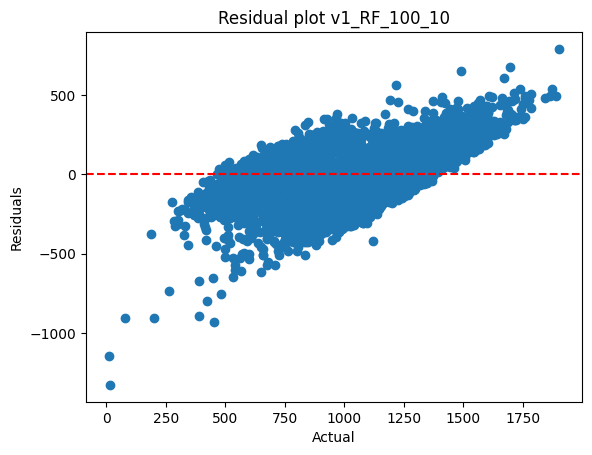

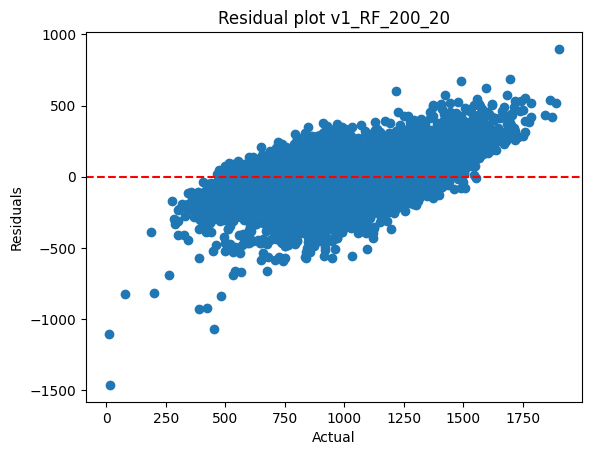

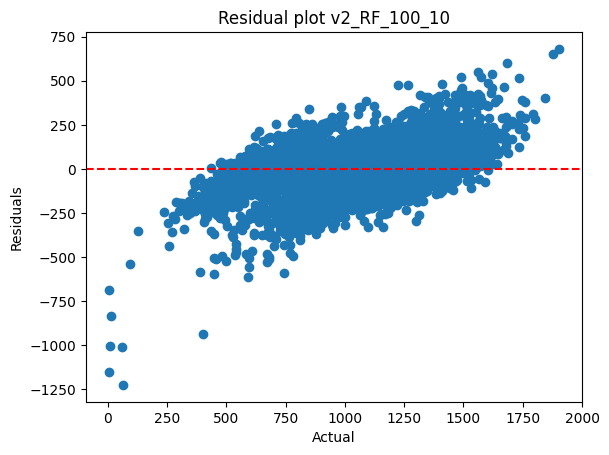

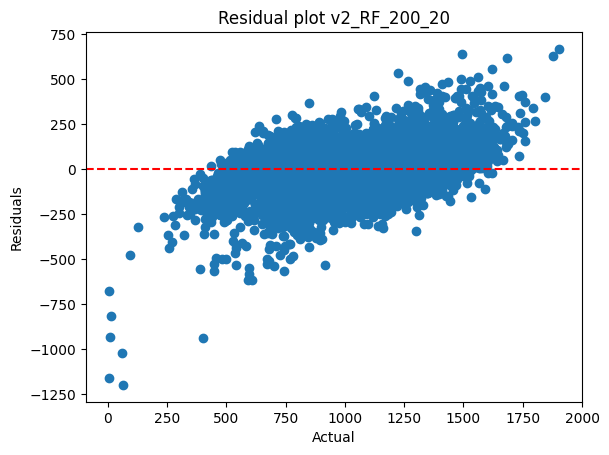

In [0]:
# Train models (4 combinations)
train_model('v1', training_set_v1, ['age', 'height', 'weight'], ['gender','howlong'], 100, 10)
train_model('v1', training_set_v1, ['age', 'height', 'weight'], ['gender','howlong'], 200, 20)
train_model('v2', training_set_v2, ['age', 'height', 'weight', 'fran', 'fgonebad', 'filthy50', 'grace', 'helen', 'run400', 'run5k'], ['gender','howlong'], 100, 10)
train_model('v2', training_set_v2, ['age', 'height', 'weight', 'fran', 'fgonebad', 'filthy50', 'grace', 'helen', 'run400', 'run5k'], ['gender','howlong'], 200, 20)

### Experiments comparison

In [0]:
exp = mlflow.get_experiment_by_name('/Workspace/Users/adqnguyen@uchicago.edu/athletes_experiments')
runs_df = mlflow.search_runs(experiment_ids=[exp.experiment_id])

In [0]:
results = runs_df[[
    'run_id',
    'params.feature_version',
    'params.num_estimators',
    'params.max_depth',
    'metrics.mse',
    'metrics.r2',
    'metrics.carbon_kg'
]].rename(columns={
    'params.feature_version':'feature_version',
    'params.num_estimators':'n_estimators',
    'params.max_depth':'max_depth',
})

results['experiment'] = results.apply(lambda r: f"{r['feature_version']} | {r['n_estimators']} trees | depth {r['max_depth']}",axis=1)

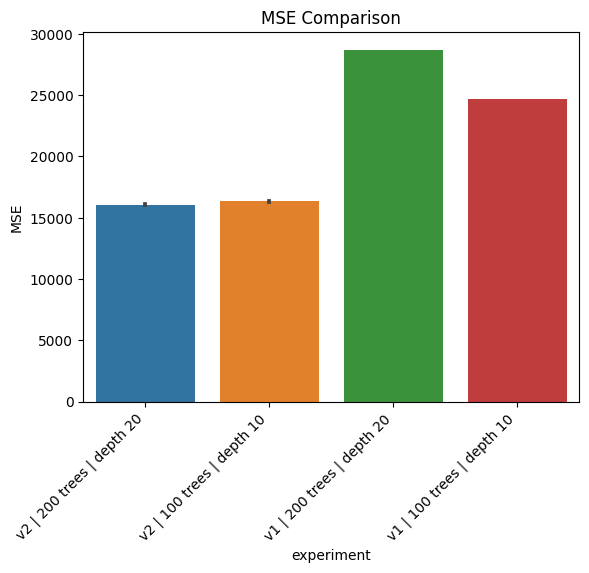

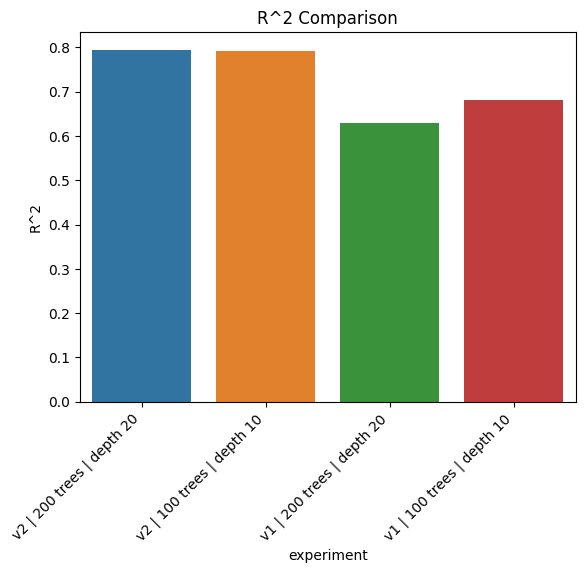

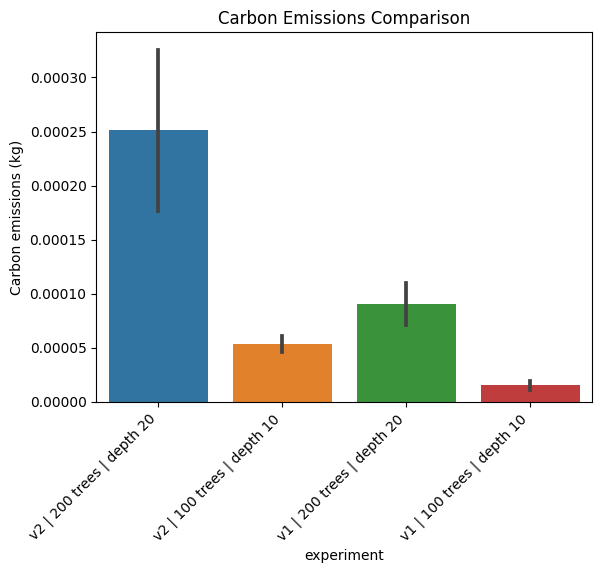

In [0]:
import seaborn as sns

#Plot MSE
sns.barplot(data=results, x='experiment', y='metrics.mse')
plt.title('MSE Comparison')
plt.xticks(rotation=45, ha='right')
plt.ylabel('MSE')
plt.show()

#Plot R^2
sns.barplot(data=results, x='experiment', y='metrics.r2')
plt.title('R^2 Comparison')
plt.xticks(rotation=45, ha='right')
plt.ylabel('R^2')
plt.show()

#Plot Carbon Emissions
sns.barplot(data=results, x='experiment', y='metrics.carbon_kg')
plt.title('Carbon Emissions Comparison')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Carbon emissions (kg)')
plt.show()


#### Comparing the 4 runs
Across the runs, the two models trained on features version 2 perform similarly with roughly the same MSE and R^2. For the two models trained on features version 1, the MSE are higher than that of the version 2, while the R^2 are both lower, suggesting that version 1 models might not perform as well. However, looking at the residual plots, we see that across model, the residuals seem to increase as the actual value increases, suggesting the models are suffering from heteroskedasticity. We should consider transforming the target variable to improve model performance. Finally, the carbon emissions is highest for version 2 features trained with more trees and higher maximum depth, showing that the emissions increase quickly with more features, more trees, and higher maximum depth.